In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s e

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


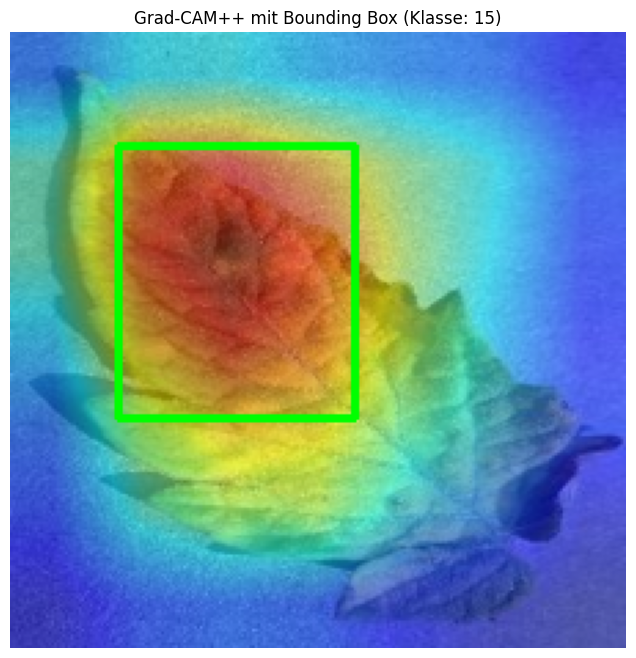

In [3]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import pickle

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ========== MODEL LOADING ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('advanced_ml_project_model_vF.pkl', 'rb') as f:
    model_info = pickle.load(f)

num_classes = model_info['num_classes']

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(model_info['state_dict'])
model.to(device).eval()

# ========== IMAGE PREPROCESSING ==========
image_path = "/content/Test"  # <-- Pfad zum Bild anpassen
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0).to(device)
rgb_image = np.array(image.resize((224, 224))) / 255.0  # für Overlay

# ========== Grad-CAM++ ==========
target_layers = [model.layer4[-1]]  # letzter Conv-Block von ResNet18
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# Klasse mit höchster Wahrscheinlichkeit bestimmen
with torch.no_grad():
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

# Grad-CAM++ Heatmap erzeugen
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]  # (H, W), Werte 0-1

# ========== Heatmap überlagern ==========
heatmap = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# ===== BOUNDING =====
# Statt Otsu: fester Threshold für schärfere Aktivierungsbereiche
threshold_value = 0.7
binary_map = (grayscale_cam > threshold_value).astype(np.uint8) * 255

# Erosion für engere Bereiche
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.erode(binary_map, kernel, iterations=1)

# Konturen & Boxen
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
overlay = np.uint8(heatmap.copy())

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    # Optional: kleinen Puffer von -2 Pixeln links/rechts (Box enger)
    padding = 2
    x = max(x + padding, 0)
    y = max(y + padding, 0)
    w = max(w - 2 * padding, 1)
    h = max(h - 2 * padding, 1)

    cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)

# ========== ANZEIGE ==========
plt.figure(figsize=(8, 8))
plt.imshow(overlay)
plt.title(f"Grad-CAM++ mit Bounding Box (Klasse: {class_idx})")
plt.axis('off')
plt.show()